In [1]:
# load images with tf.data.Dataset
# see here: https://www.tensorflow.org/tutorials/load_data/images
import tensorflow as tf
print(tf.__version__)
import pandas as pd
import numpy as np
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE
import pathlib
from code.dataset import *

df_sizes = pd.read_csv("data/data/sorted_metadata.csv")
path="data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
BATCH_SIZE = 32
IMG_HEIGHT = int(df_sizes.n_rows.mean()/2)
IMG_WIDTH = int(df_sizes.n_cols.mean()/2)
CLASS_NAMES = np.array(["Normal", "Pnemonia"])
test_path = f"{path}/test_modified"
data_dir = pathlib.Path(test_path)
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

filename = 'data/test_cache'
test_ds = prepare_dataset(labeled_ds,cache=filename,testing_bool=True, AUTOTUNE=AUTOTUNE)

2.0.0


## Build ResNet model, load weights

In [2]:
data_format = "channels_last"
inp_shape = (IMG_HEIGHT,IMG_WIDTH,1) # channels_last
input_tensor = None
resnet = tf.keras.applications.ResNet50(
    include_top=True, weights=None, input_tensor=input_tensor, input_shape=inp_shape,
    pooling=None, classes=2
)

In [3]:
num_examples = df_sizes[df_sizes.dataset_type == "TEST"].shape[0]
print("Number of test samples: {}".format(num_examples))
num_classes = CLASS_NAMES.shape[0]

# get true labels from test set
y_true = np.zeros((num_examples,num_classes))
for i, batch in zip(range(num_examples), test_ds.take(num_examples)):
    y_true[i,:] = batch[1]

Number of test samples: 624


Evaluate model with weights from `epoch` in `epoch_list`.

In [8]:
y_hat_list = []
epoch_list = [10,25,50,100]
for epoch_val in epoch_list:
    # model_out_base = "{}/model_H{}_W{}_unique_{:03d}epoch".format(model_path,IMG_HEIGHT,IMG_WIDTH,epoch_val)
    weights_out_base = "weights/resnet50/H{}_W{}/weights-{:02d}".format(IMG_HEIGHT,IMG_WIDTH,epoch_val)
    weights_file = "{}.h5".format(weights_out_base)
    print("--- Evaluating ResNet50 using weights from {} ---".format(weights_file))
    resnet.load_weights(weights_file)
    resnet.compile(optimizer='adam',
                   loss=tf.keras.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy']
                  ) 
    y_hat = resnet.predict(test_ds,steps=num_examples)
    y_hat_list.append(y_hat)

--- Evaluating ResNet50 using weights from weights/resnet50/H486_W664/weights-10.h5 ---
--- Evaluating ResNet50 using weights from weights/resnet50/H486_W664/weights-25.h5 ---
--- Evaluating ResNet50 using weights from weights/resnet50/H486_W664/weights-50.h5 ---
--- Evaluating ResNet50 using weights from weights/resnet50/H486_W664/weights-100.h5 ---


## CNN Classification Metrics

For now, we only do binary classification. The metrics we look at are:
- ROC/PR Curves
- Confusion Matrix

ResNet outputs are probabilities (softmax)

## ROC Curves

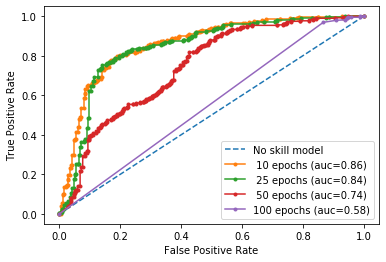

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.plot([0,1], [0,1], linestyle='--', label='No skill model')
for epochs, y_hat in zip(epoch_list, y_hat_list):
    y_probs = y_hat[:,1] # second column is "Pnemonia"
    fpr, tpr, _ = roc_curve(y_true[:,1], y_probs)
    auc = roc_auc_score(y_true, y_hat)
    plt.plot(fpr, tpr, marker='.', label='{:3} epochs (auc={:3.2f})'.format(epochs, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Precision-Recall Curve

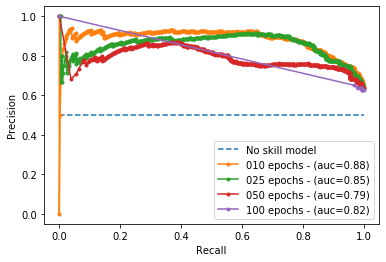

In [11]:
from sklearn.metrics import precision_recall_curve, auc, f1_score

plt.plot([0,1], [0.5,0.5], linestyle='--', label='No skill model')
for epochs, y_hat in zip(epoch_list, y_hat_list):
    y_probs = y_hat[:,1] # second column is "Pnemonia"
    precision, recall, thresholds = precision_recall_curve(y_true[:,1],y_probs)
    auc_val = auc(recall, precision)
    plt.plot(recall, precision, marker='.', label='{:03d} epochs - (auc={:3.2f})'.format(epochs, auc_val))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Confusion Matrix

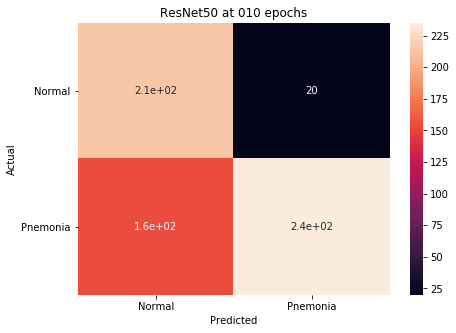

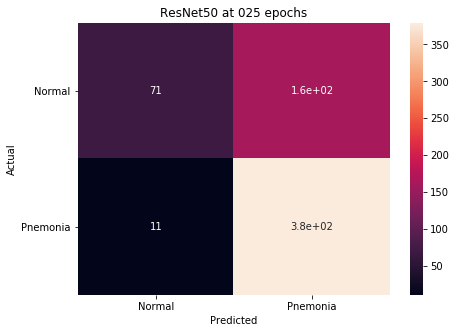

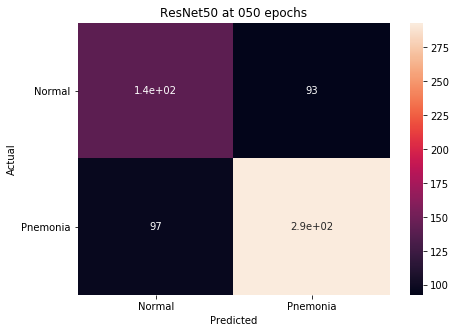

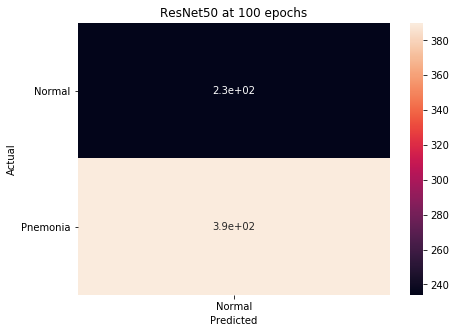

In [13]:
import pandas as pd
import seaborn as sn

for epochs, y_hat in zip(epoch_list, y_hat_list):
    # convert resnet output to onehot
    y_one_hot = np.squeeze(tf.one_hot(tf.nn.top_k(y_hat).indices, tf.shape(y_hat)[1]).numpy())
    data = {"y_test": y_true[:,1], "y_hat": y_one_hot[:,1]}
    df = pd.DataFrame(data, columns=["y_test", "y_hat"])
    confusion_matrix = pd.crosstab(df['y_test'],df['y_hat'],rownames=["Actual"],colnames=['Predicted'])
    f, ax = plt.subplots(figsize=(7,5))
    sn.heatmap(confusion_matrix, annot=True)
    ax.yaxis.set_ticklabels(CLASS_NAMES,rotation="horizontal")
    ax.xaxis.set_ticklabels(CLASS_NAMES)
    ax.set_title("ResNet50 at {:03d} epochs".format(epochs))
    plt.show()